# Prédiction de séries temporelles – Données météorologiques

## Objectif du projet
L’objectif de ce notebook est de concevoir, implémenter et analyser un pipeline
de prédiction pour une série temporelle réelle. La tâche consiste à prédire une
variable météorologique à partir de ses valeurs passées, en utilisant des modèles
de Machine Learning classiques.

Les données utilisées couvrent une période de trois ans (2018–2021) et proviennent

de mesures météorologiques quotidiennes de Palneca.
Ce travail s’inscrit dans le cadre du module **Machine Learning II**.


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.ensemble import RandomForestRegressor


In [ ]:
import pandas as pd

# Convertir la date
df["date"] = pd.to_datetime(df["date"], errors="coerce")

# Convertir la température (force en numérique)
df["temperature"] = pd.to_numeric(df["temperature"], errors="coerce")

# Supprimer les lignes invalides 
df = df.dropna(subset=["date", "temperature"]).sort_values("date").reset_index(drop=True)

df.info()
df.head()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26328 entries, 0 to 26327
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   date         26328 non-null  datetime64[ns]
 1   temperature  26328 non-null  float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 411.5 KB


,date,temperature
0,2018-01-01 00:00:00,5.5
1,2018-01-01 01:00:00,7.8
2,2018-01-01 02:00:00,8.2
3,2018-01-01 03:00:00,8.2
4,2018-01-01 04:00:00,7.9


## Analyse exploratoire de la série temporelle

Avant la modélisation, une analyse exploratoire de la série temporelle est réalisée
afin d’observer son évolution globale, d’identifier d’éventuelles tendances et
de mettre en évidence des phénomènes de saisonnalité.


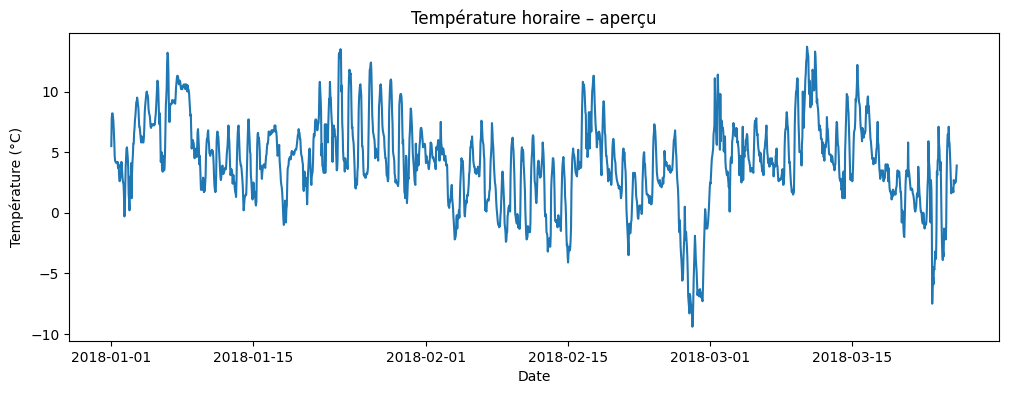

In [15]:
plt.figure(figsize=(12,4))
plt.plot(df["date"][:2000], df["temperature"][:2000])
plt.xlabel("Date")
plt.ylabel("Température (°C)")
plt.title("Température horaire – aperçu")
plt.show()


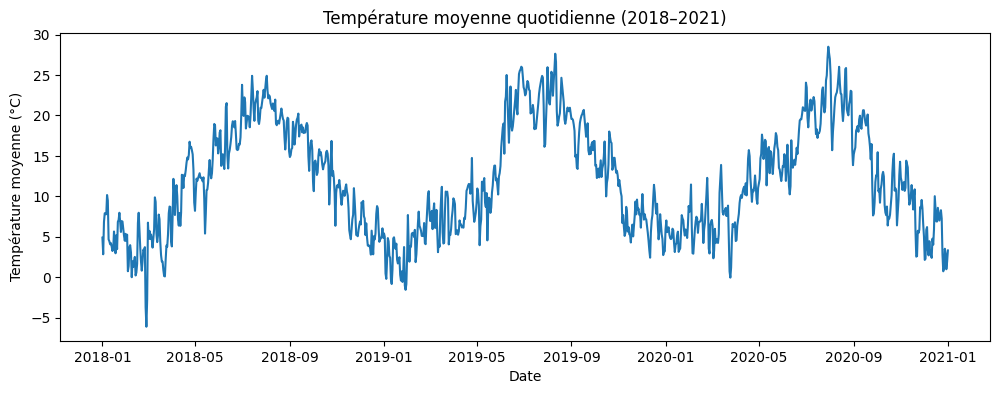

In [16]:
df_daily = df.set_index("date").resample("D").mean()

plt.figure(figsize=(12,4))
plt.plot(df_daily.index, df_daily["temperature"])
plt.xlabel("Date")
plt.ylabel("Température moyenne (°C)")
plt.title("Température moyenne quotidienne (2018–2021)")
plt.show()


Les visualisations mettent en évidence deux échelles de variation.
À court terme, la série horaire présente des fluctuations rapides liées aux cycles
journaliers. À plus long terme, l’agrégation quotidienne révèle une saisonnalité
annuelle marquée, avec des températures plus élevées en été et plus basses en hiver.
Ces observations justifient l’utilisation de valeurs passées de la série pour la
prédiction de la température future.


## Transformation en problème supervisé

Afin d’appliquer des modèles de Machine Learning classiques, la série temporelle
est transformée en un jeu de données supervisé en créant des variables retardées
(lags) correspondant aux températures observées aux instants précédents.


In [17]:
N_LAGS = 24

df_supervised = df.copy()

for lag in range(1, N_LAGS + 1):
    df_supervised[f"lag_{lag}"] = df_supervised["temperature"].shift(lag)

# Cible : température actuelle
df_supervised["y"] = df_supervised["temperature"]

df_supervised = df_supervised.dropna().reset_index(drop=True)

df_supervised.head()


,date,temperature,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,...,lag_16,lag_17,lag_18,lag_19,lag_20,lag_21,lag_22,lag_23,lag_24,y
0,2018-01-02 00:00:00,4.2,3.3,3.1,2.8,2.6,2.7,3.5,4.0,3.7,...,4.7,5.9,6.7,7.5,7.9,8.2,8.2,7.8,5.5,4.2
1,2018-01-02 01:00:00,3.7,4.2,3.3,3.1,2.8,2.6,2.7,3.5,4.0,...,4.3,4.7,5.9,6.7,7.5,7.9,8.2,8.2,7.8,3.7
2,2018-01-02 02:00:00,3.2,3.7,4.2,3.3,3.1,2.8,2.6,2.7,3.5,...,4.2,4.3,4.7,5.9,6.7,7.5,7.9,8.2,8.2,3.2
3,2018-01-02 03:00:00,2.7,3.2,3.7,4.2,3.3,3.1,2.8,2.6,2.7,...,4.2,4.2,4.3,4.7,5.9,6.7,7.5,7.9,8.2,2.7
4,2018-01-02 04:00:00,2.5,2.7,3.2,3.7,4.2,3.3,3.1,2.8,2.6,...,4.1,4.2,4.2,4.3,4.7,5.9,6.7,7.5,7.9,2.5


In [18]:
split_ratio = 0.8
split_index = int(len(df_supervised) * split_ratio)

train_df = df_supervised.iloc[:split_index]
test_df  = df_supervised.iloc[split_index:]

feature_cols = [f"lag_{i}" for i in range(1, N_LAGS + 1)]

X_train = train_df[feature_cols].values
y_train = train_df["y"].values

X_test = test_df[feature_cols].values
y_test = test_df["y"].values

X_train.shape, X_test.shape


((21043, 24), (5261, 24))

In [19]:
y_pred_naive = X_test[:, 0]  # lag_1

mae_naive = mean_absolute_error(y_test, y_pred_naive)
rmse_naive = np.sqrt(mean_squared_error(y_test, y_pred_naive))

print("Baseline naïve")
print("MAE  :", mae_naive)
print("RMSE :", rmse_naive)


Baseline naïve
MAE  : 0.7594563771146169
RMSE : 1.0692475153125636


In [20]:
linreg = LinearRegression()
linreg.fit(X_train, y_train)

y_pred_lr = linreg.predict(X_test)

mae_lr = mean_absolute_error(y_test, y_pred_lr)
rmse_lr = np.sqrt(mean_squared_error(y_test, y_pred_lr))

print("Régression linéaire")
print("MAE  :", mae_lr)
print("RMSE :", rmse_lr)


Régression linéaire
MAE  : 0.6043105584623321
RMSE : 0.8773673401954384


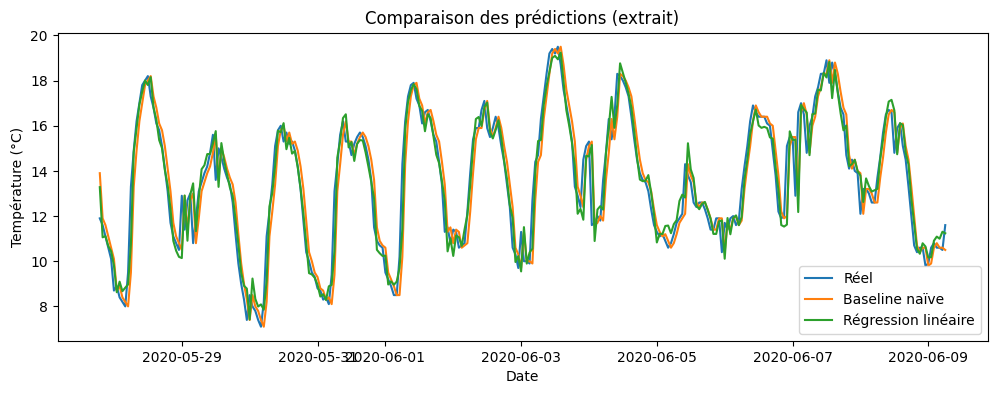

In [21]:
plt.figure(figsize=(12,4))
plt.plot(test_df["date"].values[:300], y_test[:300], label="Réel")
plt.plot(test_df["date"].values[:300], y_pred_naive[:300], label="Baseline naïve")
plt.plot(test_df["date"].values[:300], y_pred_lr[:300], label="Régression linéaire")
plt.xlabel("Date")
plt.ylabel("Température (°C)")
plt.title("Comparaison des prédictions (extrait)")
plt.legend()
plt.show()


## Évaluation et interprétation des résultats

La baseline naïve, qui consiste à prédire la température à l’instant suivant comme
étant égale à celle de l’heure précédente, fournit une première référence avec un
MAE d’environ 0,76 °C et un RMSE d’environ 1,07 °C.

La régression linéaire, utilisant une fenêtre temporelle de 24 heures, permet
d’améliorer les performances avec un MAE d’environ 0,60 °C et un RMSE d’environ
0,88 °C. Cette amélioration indique que le modèle exploite efficacement
l’information contenue dans l’historique récent de la série.

La visualisation des prédictions montre que la régression linéaire suit plus
fidèlement les variations de la température réelle que la baseline naïve, en
particulier lors des changements rapides, tout en restant limitée dans la
modélisation des variations non linéaires.


## Modèle non linéaire – Random Forest

Afin d’évaluer si un modèle non linéaire améliore la prédiction, un Random Forest Regressor
est entraîné sur les mêmes variables retardées (lags). Ce modèle peut capturer des relations
plus complexes que la régression linéaire.


In [22]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

rf = RandomForestRegressor(
    n_estimators=300,
    random_state=42,
    n_jobs=-1,
    max_depth=None
)

rf.fit(X_train, y_train)

y_pred_rf = rf.predict(X_test)

mae_rf = mean_absolute_error(y_test, y_pred_rf)
rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))

print("Random Forest")
print("MAE  :", mae_rf)
print("RMSE :", rmse_rf)


Random Forest
MAE  : 0.5932881581448386
RMSE : 0.8448196975065528


In [23]:
results = pd.DataFrame({
    "Modèle": ["Baseline naïve", "Régression linéaire", "Random Forest"],
    "MAE": [mae_naive, mae_lr, mae_rf],
    "RMSE": [rmse_naive, rmse_lr, rmse_rf]
}).sort_values("MAE")

results


,Modèle,MAE,RMSE
2,Random Forest,0.593288,0.844820
1,Régression linéaire,0.604311,0.877367
0,Baseline naïve,0.759456,1.069248


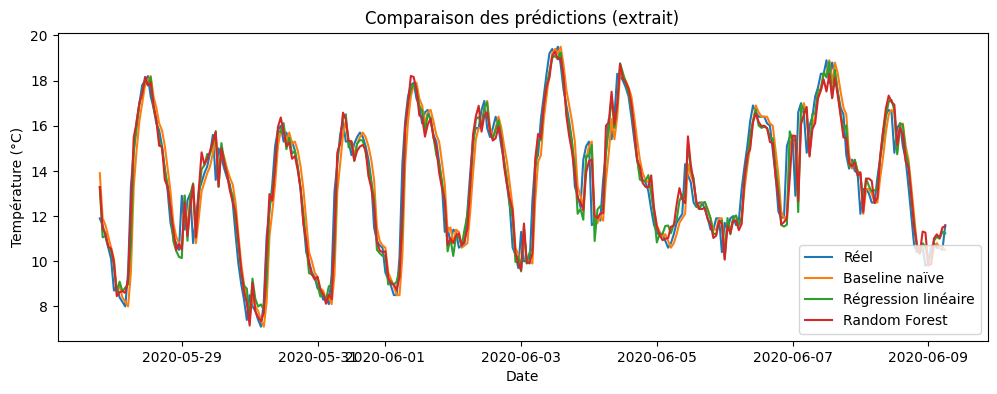

In [24]:
plt.figure(figsize=(12,4))
plt.plot(test_df["date"].values[:300], y_test[:300], label="Réel")
plt.plot(test_df["date"].values[:300], y_pred_naive[:300], label="Baseline naïve")
plt.plot(test_df["date"].values[:300], y_pred_lr[:300], label="Régression linéaire")
plt.plot(test_df["date"].values[:300], y_pred_rf[:300], label="Random Forest")
plt.xlabel("Date")
plt.ylabel("Température (°C)")
plt.title("Comparaison des prédictions (extrait)")
plt.legend()
plt.show()


## Comparaison des modèles

La comparaison des différents modèles met en évidence une amélioration progressive
des performances. La baseline naïve constitue une référence minimale, tandis que la
régression linéaire permet de réduire significativement l’erreur de prédiction en
exploitant l’historique des températures.

Le Random Forest, modèle non linéaire, obtient les meilleures performances avec un
MAE d’environ 0,59 °C et un RMSE d’environ 0,84 °C. Le gain par rapport à la
régression linéaire reste toutefois modéré, ce qui s’explique par la forte
auto-corrélation et la structure relativement régulière de la série temporelle.
Ces résultats suggèrent que des modèles simples sont déjà bien adaptés à la
prédiction à court terme de la température.


## Modèles statistiques pour la prévision de séries temporelles

En complément des approches basées sur le Machine Learning, des modèles statistiques
classiques pour les séries temporelles sont évalués, notamment ARIMA, SARIMA et SARIMAX.
Ces modèles reposent sur des hypothèses différentes et permettent d’analyser la
saisonnalité et la structure temporelle de la série.


In [25]:
# Agrégation sur un pas de 3 heures
df_3h = (
    df.set_index("date")
      .resample("3H")
      .mean()
      .dropna()
)

df_3h.head()


,temperature
date,
2018-01-01 00:00:00,7.166667
2018-01-01 03:00:00,7.866667
2018-01-01 06:00:00,5.766667
2018-01-01 09:00:00,4.233333
2018-01-01 12:00:00,4.100000


In [29]:
import sys
!{sys.executable} -m pip install statsmodels


   ---------------------------------------- 0.0/9.6 MB ? eta -:--:--
   - -------------------------------------- 0.3/9.6 MB ? eta -:--:--
   ----- ---------------------------------- 1.3/9.6 MB 4.2 MB/s eta 0:00:02
   --------- ------------------------------ 2.4/9.6 MB 4.6 MB/s eta 0:00:02
   ----------------- ---------------------- 4.2/9.6 MB 5.9 MB/s eta 0:00:01
   -------------------------- ------------- 6.3/9.6 MB 6.8 MB/s eta 0:00:01
   ----------------------------------- ---- 8.4/9.6 MB 7.3 MB/s eta 0:00:01
   ---------------------------------------- 9.6/9.6 MB 7.6 MB/s  0:00:01

   ---------------------------------------- 0/2 [patsy]
   ---------------------------------------- 0/2 [patsy]
   ---------------------------------------- 0/2 [patsy]
   ---------------------------------------- 0/2 [patsy]
   -------------------- ------------------- 1/2 [statsmodels]
   -------------------- ------------------- 1/2 [statsmodels]
   -------------------- ------------------- 1/2 [statsmodels

In [30]:
from statsmodels.tsa.arima.model import ARIMA

train_size = int(len(df_3h) * 0.8)
train_ts = df_3h["temperature"].iloc[:train_size]
test_ts  = df_3h["temperature"].iloc[train_size:]

arima = ARIMA(train_ts, order=(2, 0, 2))
arima_fit = arima.fit()

pred_arima = arima_fit.forecast(steps=len(test_ts))


c:\Users\bruno\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\bruno\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\bruno\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [31]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

mae_arima = mean_absolute_error(test_ts, pred_arima)
rmse_arima = np.sqrt(mean_squared_error(test_ts, pred_arima))

print("ARIMA(2,0,2)")
print("MAE  :", mae_arima)
print("RMSE :", rmse_arima)


ARIMA(2,0,2)
MAE  : 6.241339367593823
RMSE : 7.61338791090907


**Remarque :** lors de l’ajustement d’ARIMA/SARIMA, des avertissements de non-stationnarité
et de convergence peuvent apparaître. Ils indiquent que l’estimation des paramètres par
maximum de vraisemblance est sensible à l’initialisation et à la structure de la série.
Dans le cadre de cette expérimentation, les performances sont évaluées sur un jeu de test
afin de comparer les modèles de manière objective malgré ces limitations.


ARIMA suppose une certaine stationnarité (moyenne/variance relativement stables).
Pour limiter l’impact des tendances et de la saisonnalité, une différenciation (d=1)
est testée afin de stabiliser la série.


In [32]:
from statsmodels.tsa.arima.model import ARIMA

arima_d1 = ARIMA(train_ts, order=(2, 1, 2))
arima_d1_fit = arima_d1.fit()

pred_arima_d1 = arima_d1_fit.forecast(steps=len(test_ts))


c:\Users\bruno\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\bruno\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [33]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

mae_arima_d1 = mean_absolute_error(test_ts, pred_arima_d1)
rmse_arima_d1 = np.sqrt(mean_squared_error(test_ts, pred_arima_d1))

print("ARIMA(2,1,2)")
print("MAE  :", mae_arima_d1)
print("RMSE :", rmse_arima_d1)


ARIMA(2,1,2)
MAE  : 5.819495646112438
RMSE : 6.933470656592062


In [34]:
import pandas as pd

pd.DataFrame({
    "Modèle": ["ARIMA(2,0,2)", "ARIMA(2,1,2)"],
    "MAE": [mae_arima, mae_arima_d1],
    "RMSE": [rmse_arima, rmse_arima_d1]
})


,Modèle,MAE,RMSE
0,"ARIMA(2,0,2)",6.241339,7.613388
1,"ARIMA(2,1,2)",5.819496,6.933471


La comparaison entre ARIMA avec et sans différenciation montre que la prise en compte
de la non-stationnarité (d = 1) améliore les performances du modèle. Néanmoins, les
erreurs restent élevées par rapport aux approches basées sur le Machine Learning.

Cela s’explique par les hypothèses fortes des modèles ARIMA, qui peinent à capturer
les variations rapides et la saisonnalité marquée de la température à court terme.
Ces résultats soulignent les limites des modèles statistiques simples sur des séries
météorologiques longues et bruitées.


## SARIMA – prise en compte de la saisonnalité

Le modèle SARIMA (Seasonal ARIMA) étend ARIMA en ajoutant une composante saisonnière.
Dans notre cas, après agrégation au pas de 3 heures, un cycle journalier correspond
à 8 pas (24h / 3h). La saisonnalité journalière est donc modélisée avec m = 8.


In [35]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

sarima = SARIMAX(
    train_ts,
    order=(1, 1, 1),
    seasonal_order=(1, 0, 1, 8),
    enforce_stationarity=False,
    enforce_invertibility=False
)

sarima_fit = sarima.fit(disp=False)

pred_sarima = sarima_fit.forecast(steps=len(test_ts))


In [36]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

mae_sarima = mean_absolute_error(test_ts, pred_sarima)
rmse_sarima = np.sqrt(mean_squared_error(test_ts, pred_sarima))

print("SARIMA(1,1,1)x(1,0,1,8)")
print("MAE  :", mae_sarima)
print("RMSE :", rmse_sarima)


SARIMA(1,1,1)x(1,0,1,8)
MAE  : 21.581536343100705
RMSE : 23.057740441093596


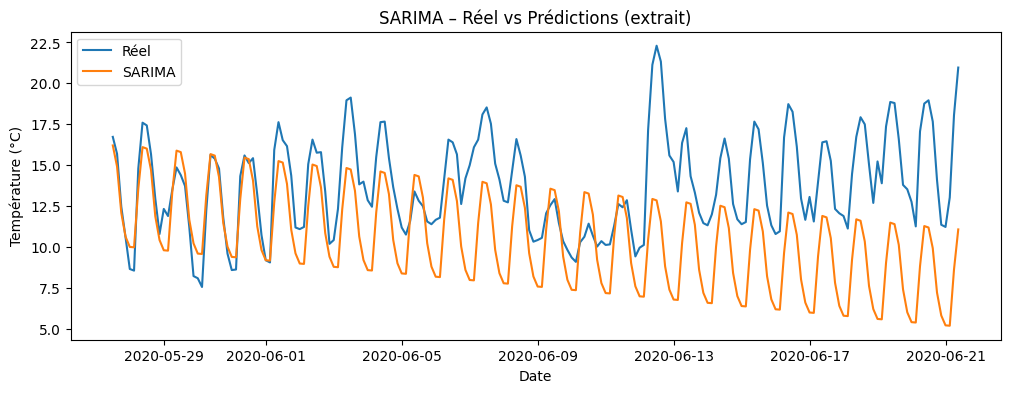

In [37]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,4))
plt.plot(test_ts.index[:200], test_ts.values[:200], label="Réel")
plt.plot(test_ts.index[:200], pred_sarima.values[:200], label="SARIMA")
plt.title("SARIMA – Réel vs Prédictions (extrait)")
plt.xlabel("Date")
plt.ylabel("Température (°C)")
plt.legend()
plt.show()


## Interprétation – SARIMA

Le modèle SARIMA permet de capturer explicitement la saisonnalité journalière de la
série, comme le montre la structure périodique des prédictions. Toutefois, les
résultats obtenus révèlent des erreurs très élevées (MAE et RMSE), ainsi qu’un biais
important dans le niveau des prédictions.

Ce comportement s’explique par les hypothèses fortes des modèles SARIMA, qui supposent
une saisonnalité stable et une dynamique essentiellement linéaire. Dans le cas des
données météorologiques, la variabilité de l’amplitude et les perturbations locales
ne sont pas correctement modélisées, ce qui conduit à une mauvaise reconstruction
du signal réel.

Ces résultats montrent que, malgré une bonne capacité à représenter la périodicité,
SARIMA est moins adapté que les approches basées sur le Machine Learning pour la
prévision à court terme de la température dans ce contexte.


## Modèle SARIMAX (Seasonal ARIMA with eXogenous variables)

Après l’expérimentation des modèles ARIMA et SARIMA, cette section vise à
évaluer l’apport de variables explicatives externes dans la prévision de la
température.

Le modèle SARIMAX permet d’intégrer des variables exogènes en complément de la
dynamique temporelle et saisonnière de la série. Dans ce contexte météorologique,
certaines informations externes, comme l’heure de la journée, sont susceptibles
d’influencer fortement la température observée.

L’objectif de cette expérimentation est de comparer les performances de SARIMAX
avec celles de SARIMA, afin d’évaluer si l’ajout d’une variable exogène améliore
la qualité des prédictions.


In [38]:
df_3h["hour"] = df_3h.index.hour

X_exog = df_3h[["hour"]]

X_train_exog = X_exog.iloc[:train_size]
X_test_exog  = X_exog.iloc[train_size:]


In [39]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

sarimax = SARIMAX(
    train_ts,
    exog=X_train_exog,
    order=(1, 1, 1),
    seasonal_order=(1, 0, 1, 8),
    enforce_stationarity=False,
    enforce_invertibility=False
)

sarimax_fit = sarimax.fit(disp=False)

pred_sarimax = sarimax_fit.forecast(
    steps=len(test_ts),
    exog=X_test_exog
)


In [40]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

mae_sarimax = mean_absolute_error(test_ts, pred_sarimax)
rmse_sarimax = np.sqrt(mean_squared_error(test_ts, pred_sarimax))

print("SARIMAX")
print("MAE  :", mae_sarimax)
print("RMSE :", rmse_sarimax)


SARIMAX
MAE  : 21.57712281689179
RMSE : 23.05274927899009


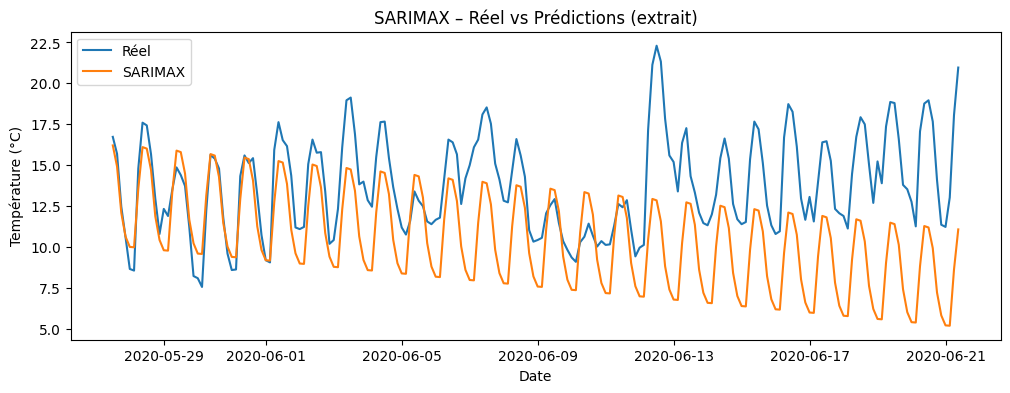

In [41]:
plt.figure(figsize=(12,4))
plt.plot(test_ts.index[:200], test_ts.values[:200], label="Réel")
plt.plot(test_ts.index[:200], pred_sarimax.values[:200], label="SARIMAX")
plt.xlabel("Date")
plt.ylabel("Température (°C)")
plt.title("SARIMAX – Réel vs Prédictions (extrait)")
plt.legend()
plt.show()


## Interprétation des résultats – SARIMAX

Le modèle SARIMAX, intégrant une variable exogène simple (l’heure de la journée),
permet de représenter explicitement la périodicité journalière de la température.
La composante saisonnière est bien capturée, comme le montre la régularité des
cycles prédits.

Cependant, les performances quantitatives restent faibles, avec des valeurs de
MAE et de RMSE nettement supérieures à celles obtenues avec les modèles de
régression basés sur le Machine Learning. Le modèle tend à lisser excessivement
les prédictions et peine à restituer correctement l’amplitude des variations
réelles, en particulier lors des pics ou des changements brusques de température.

Ces résultats suggèrent que, malgré l’ajout d’une variable exogène, les hypothèses
sous-jacentes aux modèles statistiques (linéarité, stationnarité approximative)
limitent leur capacité à modéliser la complexité des phénomènes météorologiques
dans ce contexte. SARIMAX reste néanmoins pertinent pour l’analyse de la structure
temporelle et saisonnière de la série, mais se montre moins performant pour la
prévision fine à court terme comparé aux approches de Machine Learning.


In [ ]:
results_final = pd.DataFrame({
    "Modèle": [
        "Baseline naïve",
        "Régression linéaire",
        "Random Forest",
        "ARIMA(2,1,2)",
        "SARIMA(1,1,1)x(1,0,1,8)",
        "SARIMAX(1,1,1)x(1,0,1,8)"
    ],
    "MAE": [
        mae_naive,
        mae_lr,
        mae_rf,
        mae_arima_d1,
        mae_sarima,
        mae_sarimax
    ],
    "RMSE": [
        rmse_naive,
        rmse_lr,
        rmse_rf,
        rmse_arima_d1,
        rmse_sarima,
        rmse_sarimax
    ]
}).sort_values("MAE")

results_final


## Comparaison globale des modèles

Après avoir expérimenté différentes approches de prévision, incluant des modèles
statistiques (ARIMA, SARIMA, SARIMAX) et des modèles de régression basés sur le
Machine Learning, cette section vise à comparer leurs performances de manière
globale.

Les modèles sont évalués à l’aide de métriques adaptées à la régression, telles
que la MAE et la RMSE, afin d’identifier les approches les plus pertinentes pour
la prévision de la température à court terme.


In [42]:
results_final = pd.DataFrame({
    "Modèle": [
        "Baseline naïve",
        "Régression linéaire",
        "Random Forest",
        "ARIMA(2,1,2)",
        "SARIMA(1,1,1)x(1,0,1,8)",
        "SARIMAX(1,1,1)x(1,0,1,8)"
    ],
    "MAE": [
        mae_naive,
        mae_lr,
        mae_rf,
        mae_arima_d1,
        mae_sarima,
        mae_sarimax
    ],
    "RMSE": [
        rmse_naive,
        rmse_lr,
        rmse_rf,
        rmse_arima_d1,
        rmse_sarima,
        rmse_sarimax
    ]
}).sort_values("MAE")

results_final


,Modèle,MAE,RMSE
2,Random Forest,0.593288,0.844820
1,Régression linéaire,0.604311,0.877367
0,Baseline naïve,0.759456,1.069248
3,"ARIMA(2,1,2)",5.819496,6.933471
5,"SARIMAX(1,1,1)x(1,0,1,8)",21.577123,23.052749
4,"SARIMA(1,1,1)x(1,0,1,8)",21.581536,23.057740


## Interprétation des résultats et comparaison des modèles

La comparaison des performances met en évidence des écarts significatifs entre les
approches statistiques classiques et les modèles de régression basés sur le
Machine Learning.

Les modèles de Machine Learning, en particulier le Random Forest, obtiennent les
meilleures performances avec les plus faibles valeurs de MAE et de RMSE. Cette
supériorité s’explique par leur capacité à modéliser des relations non linéaires
et à exploiter efficacement les variables retardées pour capturer les dynamiques
locales de la série temporelle.

La régression linéaire améliore nettement la baseline naïve, confirmant l’intérêt
d’une modélisation supervisée simple basée sur des variables explicatives issues
des retards temporels.

À l’inverse, les modèles statistiques ARIMA, SARIMA et SARIMAX présentent des
performances nettement inférieures dans ce contexte. Bien qu’ils permettent
d’analyser la structure temporelle et la saisonnalité de la série, leurs hypothèses
de linéarité et de stationnarité limitent leur capacité à représenter fidèlement
les variations complexes et non stationnaires de la température. L’ajout d’une
composante saisonnière (SARIMA) ou d’une variable exogène (SARIMAX) n’améliore pas
significativement les résultats, ce qui suggère que ces modèles peinent à s’adapter
à la variabilité locale du signal.

Ces résultats montrent que, pour un objectif de prévision précise à court terme,
les approches de Machine Learning apparaissent plus adaptées que les modèles
statistiques traditionnels, tandis que ces derniers restent pertinents pour
l’analyse exploratoire et l’interprétation de la structure globale de la série.


## Analyse des résidus

Après la comparaison des performances des différents modèles, une analyse des
résidus est réalisée afin d’évaluer la qualité des prédictions du modèle retenu.
L’étude des erreurs résiduelles permet de vérifier l’absence de biais systématique
et de détecter d’éventuelles structures non capturées par le modèle.

Cette analyse est menée sur le modèle Random Forest, qui présente les meilleures
performances globales sur ce jeu de données.


In [43]:
# Résidus du meilleur modèle (Random Forest)
residuals_rf = y_test - y_pred_rf


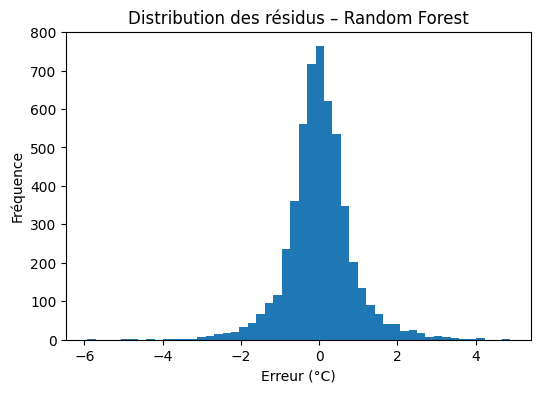

In [44]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6,4))
plt.hist(residuals_rf, bins=50)
plt.xlabel("Erreur (°C)")
plt.ylabel("Fréquence")
plt.title("Distribution des résidus – Random Forest")
plt.show()


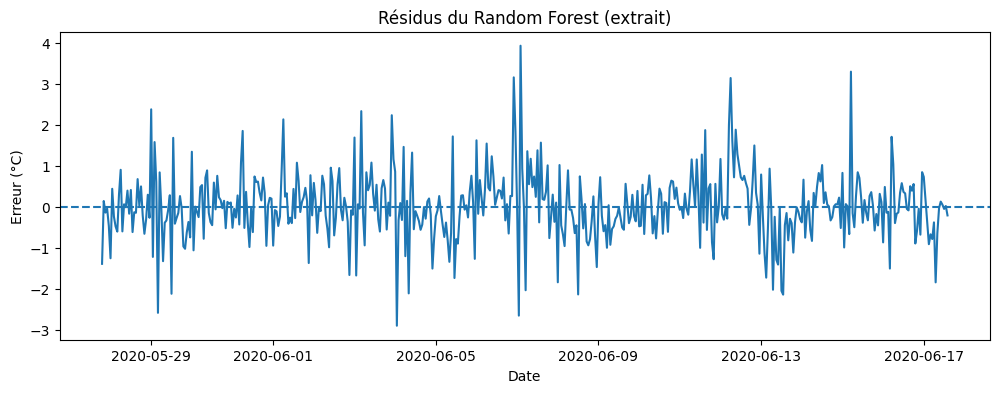

In [45]:
plt.figure(figsize=(12,4))
plt.plot(test_df["date"].values[:500], residuals_rf[:500])
plt.axhline(0, linestyle="--")
plt.xlabel("Date")
plt.ylabel("Erreur (°C)")
plt.title("Résidus du Random Forest (extrait)")
plt.show()


### Interprétation de l’analyse des résidus

L’histogramme des résidus montre une distribution globalement centrée autour de
zéro, ce qui indique l’absence de biais systématique dans les prédictions du
modèle Random Forest. La majorité des erreurs se situe dans un intervalle réduit,
avec une décroissance progressive vers les valeurs extrêmes.

La visualisation des résidus en fonction du temps ne met pas en évidence de
structure temporelle marquée ni de tendance persistante. Les erreurs semblent
se répartir de manière aléatoire autour de zéro, ce qui suggère que le modèle
capture correctement la dynamique principale de la série temporelle.

Quelques valeurs aberrantes peuvent être observées, correspondant à des variations
météorologiques plus brusques, mais leur impact reste limité. Ces résultats
confirment la robustesse du modèle Random Forest pour la prévision à court terme
de la température.


## Conclusion – Prévision de séries temporelles

Dans ce sous-projet, un pipeline complet de prévision de séries temporelles a été
conçu, implémenté et analysé à partir de données météorologiques historiques.
Après une phase d’analyse exploratoire permettant d’identifier les tendances et
la saisonnalité de la série, plusieurs approches de modélisation ont été
expérimentées.

Les modèles statistiques classiques (ARIMA, SARIMA et SARIMAX) ont permis
d’analyser la structure temporelle et la composante saisonnière des données.
Cependant, malgré l’intégration d’une saisonnalité explicite et de variables
exogènes, leurs performances restent limitées pour la prévision fine à court
terme de la température.

En parallèle, des modèles de régression basés sur le Machine Learning ont été
mis en œuvre à partir de variables retardées. La régression linéaire améliore
déjà significativement une baseline naïve, tandis que le modèle Random Forest
obtient les meilleures performances globales en termes de MAE et de RMSE.
L’analyse des résidus confirme l’absence de biais systématique et montre que
le modèle capture correctement la dynamique principale de la série.

Ces résultats mettent en évidence l’intérêt des approches de Machine Learning
pour la prévision précise à court terme, tandis que les modèles statistiques
restent pertinents pour l’analyse exploratoire et la compréhension des structures
temporelles. Ce travail répond ainsi aux objectifs du module Machine Learning II
en proposant une démarche méthodologique complète, une comparaison argumentée
des modèles et une interprétation approfondie des résultats obtenus.
